In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image as im

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 50})

In [2]:
folder = "/home/tigeriv/Data/KITTI/dataset/08"
n_classes = 11
var_thresh = 0.1

models = ["ConvBKIKITTI", "ConvBKIKITTI_Transfer", "SMNetKITTI", "SMNetKITTI_Transfer"]

meas_iou = True

model_ints = {}
model_uns = {}
model_preds = {}
model_total = {}
model_correct = {}
for model in models:
    model_ints[model] = np.zeros(n_classes)
    model_uns[model] = np.zeros(n_classes)
    model_preds[model] = []
    model_total[model] = 0
    model_correct[model] = 0

    all_gt = []

In [3]:
def iou_one_frame(pred, target, n_classes=11):
    pred = np.argmax(pred, axis=1)
    intersection = np.zeros(n_classes)
    union = np.zeros(n_classes)

    for cls in range(n_classes):
        intersection[cls] = np.sum((pred == cls) & (target == cls))
        union[cls] = np.sum((pred == cls) | (target == cls))
    return intersection, union

def accuracy_one_frame(pred, target):
    pred = np.argmax(pred, axis=1)
    
    total = target.shape[0]
    intersection = np.sum(pred == target)
    return intersection, total

In [4]:
def remap_seg(seg):
    kitti_to_carla = {
        0: 0,
        1: 10,
        2: 10,
        3: 10,
        4: 10,
        5: 10,
        6: 4,
        7: 4,
        8: 4,
        9: 6,
        10: 6,
        11: 8,
        12: 7,
        13: 1,
        14: 9,
        15: 9,
        16: 7,
        17: 7,
        18: 5,
        19: 5
    }
    new_labels = np.zeros_like(seg)
    for i in range(seg.shape[0]):
        for j in range(seg.shape[1]):
            new_labels[i, j] = kitti_to_carla[seg[i, j]]
    return new_labels

In [5]:
mask_path = os.path.join(folder, "mask")
model_dirs = {models[i]: os.path.join(folder, models[i]) for i in range(len(models))}
for frame_name in sorted(os.listdir(mask_path)):
    gt = np.fromfile(os.path.join(folder, "bev_gt", frame_name), dtype=np.uint8).reshape(256, 256)
    gt = remap_seg(gt)
    mask = np.fromfile(os.path.join(mask_path, frame_name), dtype=np.uint8).reshape(256, 256)
    in_gt = gt[mask==1]
    out_gt = gt[mask==0]
    non_zero_mask = in_gt != 0
    in_gt = in_gt[non_zero_mask]
    all_gt += list(in_gt)
    for model in models:
        preds = np.fromfile(os.path.join(model_dirs[model], frame_name), dtype=np.float32).reshape(256, 256, n_classes)
        if "ConvBKI" in model:
            semantic_labels = preds.reshape(-1, n_classes)
            semantic_sums = np.sum(semantic_labels, axis=-1, keepdims=False)
            max_labels = np.argmax(semantic_labels, axis=-1)
            point_consts = np.amax(semantic_labels, axis=-1) / semantic_sums
            point_vars = point_consts * (1 - point_consts) / (1 + semantic_sums)
            point_vars = point_vars.reshape(preds.shape[0], preds.shape[1])
            preds[point_vars > var_thresh] = 0
            preds[point_vars > var_thresh, 0] = 1
        in_preds = preds[mask==1]
        out_preds = preds[mask==0]
        in_preds = in_preds[non_zero_mask]
        if meas_iou:
            intersection, union = iou_one_frame(in_preds, in_gt, n_classes=n_classes)
            model_ints[model] += intersection
            model_uns[model] += union
            model_preds[model] += list(np.argmax(in_preds, axis=1))
        else:
            correct_i, total_i = accuracy_one_frame(in_preds, in_gt)
            model_correct[model] += correct_i
            model_total[model] += total_i

/tmp/ipykernel_1332031/2881201496.py:18: RuntimeWarning: invalid value encountered in true_divide
  point_consts = np.amax(semantic_labels, axis=-1) / semantic_sums
/tmp/ipykernel_1332031/2881201496.py:21: RuntimeWarning: invalid value encountered in greater
  preds[point_vars > var_thresh] = 0
/tmp/ipykernel_1332031/2881201496.py:22: RuntimeWarning: invalid value encountered in greater
  preds[point_vars > var_thresh, 0] = 1


In [6]:
for model in models:
    print(model)
    if meas_iou:
        iou = 100 * (model_ints[model] + 0.0001) / (model_uns[model] + 0.0001)
        for i in range(iou.shape[0]):
            print(iou[i])
        print(np.mean(iou[1:]))
    else:
        print(100 * model_correct[model] / model_total[model])

ConvBKIKITTI
2.214454408209991e-09
17.102585081053476
4.1087335222904e-08
8.748217543020919e-08
14.732357305070273
3.5289998124093223
43.512227663438
12.460386740350518
10.109404537110061
48.28859967967308
34.584251386368
18.431881233404223
ConvBKIKITTI_Transfer
5.429934031436606e-09
51.014241723819936
7.407023334044143e-08
100.0
14.08909714280659
13.302637097368118
68.90344362784548
63.465545057936396
38.94812488716485
56.56153161923772
48.103324853104596
45.438794608335385
SMNetKITTI
100.0
22.175663390021388
5.1005835041515775e-08
3.8450742661310196e-08
3.6914933925734363
7.035858658876051
40.2544587194994
22.204584141876847
18.414871189155015
49.716150758562485
27.772529611694623
19.12656099517158
SMNetKITTI_Transfer
100.0
0.026054646652113954
2.291265694645022e-08
1.5744560251953185e-08
1.607639500333361e-07
0.018845126986258592
18.530141150301805
13.699633609397555
1.3219902903880638
3.185537418565753
0.3171335750693498
3.7099336016782063


In [7]:
COLOR_MAP = {
    0: "Free",
    1: "Building",
    2: "Barrier",
    3: "Other",
    4: "Pedestrian",
    5: "Pole",
    6: "Road",
    7: "Ground",
    8: "Sidewalk",
    9: "Vegetation",
    10: "Vehicle"
}

all_labels = [COLOR_MAP[i] for i in range(1, n_classes)]

def class_to_label(preds):
    labels = [COLOR_MAP[preds[i]] for i in range(len(preds))]
    return labels

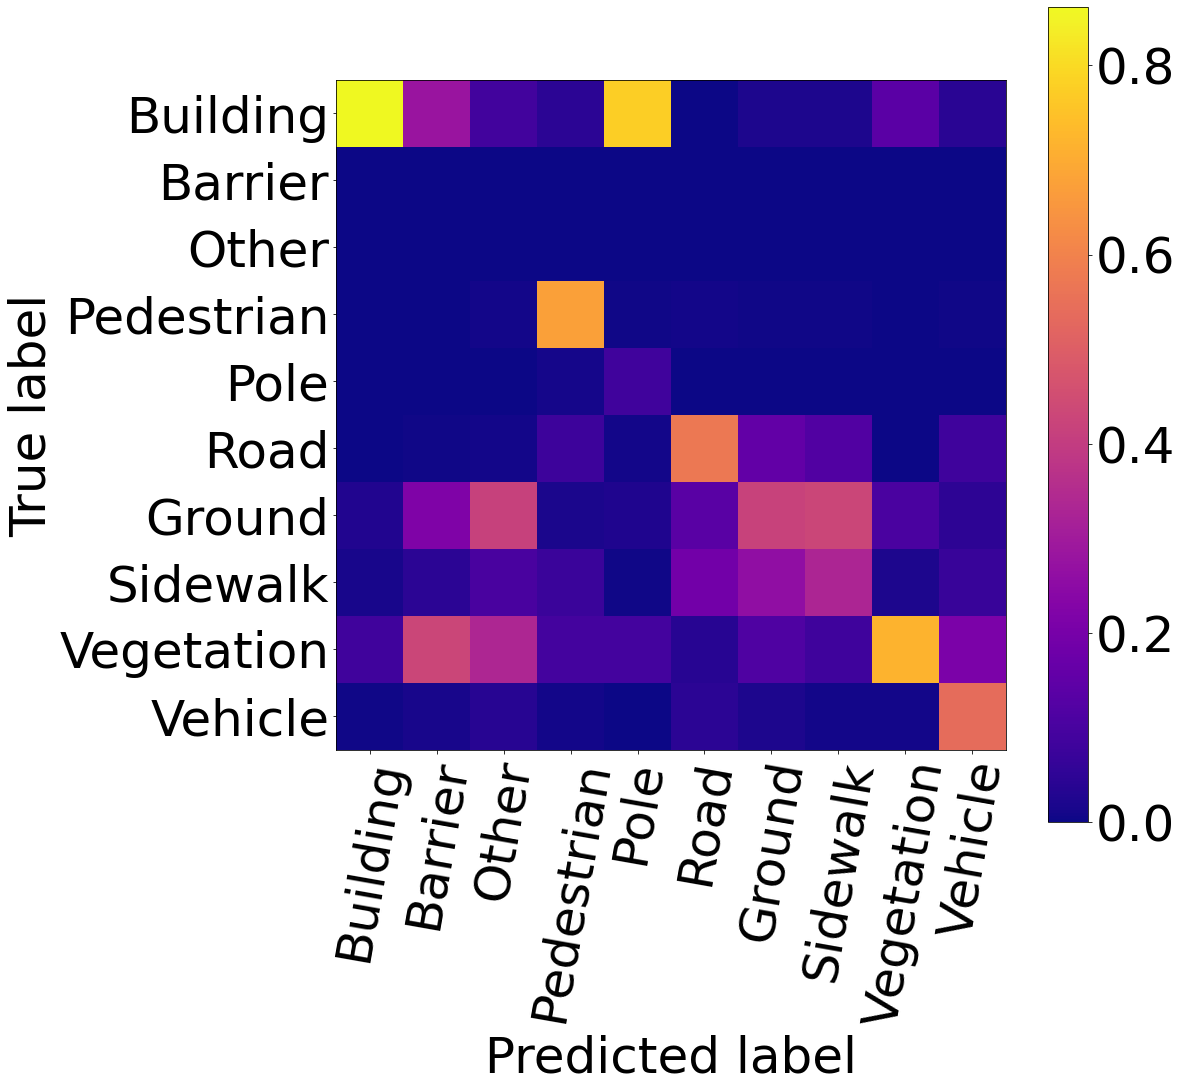

In [8]:
classes = np.array([i for i in range(1, n_classes)])

disp = ConfusionMatrixDisplay.from_predictions(np.array(all_gt), np.array(model_preds["ConvBKIKITTI"]),
                                               labels=classes, normalize="pred", include_values=False,
                                              cmap='plasma')
kept_classes = np.array([i for i in range(n_classes - 1)])
plt.xticks(kept_classes, all_labels, rotation=80)
plt.yticks(kept_classes, all_labels)
plt.show()

In [9]:
conf = confusion_matrix(np.array(all_gt), np.array(model_preds["ConvBKI"]))[1:, 1:]

KeyError: 'ConvBKI'

In [ ]:
precisions = []
recalls = []
for i in range(conf.shape[0]):
    tp = conf[i, i]
    fp = np.sum(conf[:, i]) - tp
    fn = np.sum(conf[i, :]) - tp
    precision_i = tp / (tp + fp)
    recall_i = tp / (tp + fn)
    precisions.append(precision_i)
    recalls.append(recall_i)
print(all_labels)
print(np.array(precisions) * 100)
print(np.array(recalls) * 100)